In [104]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import functions as F
import matplotlib.pyplot as plt

def assign_tensor(arr, device):
    return torch.from_numpy(arr).float().to(device)

In [ ]:
'''
cf = AttrDict() #cf = {}

cf.n_epochs = 100
cf.size_of_batch = 128
cf.data_size = None

cf.apply_inv = True
cf.label_scale = 0.94
cf.img_scale = 1.0
cf.apply_scaling = True    


cf.numperceptrons = [784, 500, 500, 10]
cf.var_out = 1
cf.activation_function = F.TANH
cf.numlayers = len(cf.numperceptrons)    
cf.variance = torch.ones(cf.numlayers)

cf.inference_beta_parameter = 0.1
cf.max_iterations = 50
cf.threshold_option = 1e-6

# optim parameters
cf.lr = 1e-3
cf.type_of_optimzer = "ADAM"
cf.adam_beta_parameter_1 = 0.9
cf.adam_beta_parameter_2 = 0.999
cf.epsilon = 1e-8
cf.decay_r = 0.9    

cf.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
'''

class NetworkForPredictiveCoding(object):
    def __init__(self, cf):

        self.device = cf.device
        self.activation_function = cf.activation_function
        
        self.adam_beta_parameter_1 = cf.adam_beta_parameter_1
        self.adam_beta_parameter_2 = cf.adam_beta_parameter_2
        self.inference_beta_parameter = cf.inference_beta_parameter
        self.lr = cf.lr
        self.threshold_option = cf.threshold_option / (sum(cf.numperceptrons) - cf.numperceptrons[0])
        
        self.numlayers = cf.numlayers
        self.numperceptrons = cf.numperceptrons
        self.variance= cf.variance.float().to(self.device)
        self.max_iterations = cf.max_iterations
        self.size_of_batch = cf.size_of_batch
        
        self.type_of_optimzer = cf.type_of_optimzer
        self.epsilon = cf.epsilon
        self.decay_r = cf.decay_r
        self.bias_constant = [[] for _ in range(self.numlayers)]
        self.weight_constant = [[] for _ in range(self.numlayers)]
        self.bias_value = [[] for _ in range(self.numlayers)]
        self.weight_value = [[] for _ in range(self.numlayers)]

        self.Weight = None
        self.bias = None
        self._parameter_intialization()
        
    def _parameter_intialization(self):
        bias = [[] for _ in range(self.numlayers)] # bias = [[], [], [] ..., []]
        weights = [[] for _ in range(self.numlayers)] # weights = [[], [], [] ..., []]

        for l in range(self.numlayers - 1):
            norm_b = 0
            if self.activation_function == F.TANH:
                weight_normalization = np.sqrt(6 / (self.numperceptrons[l + 1] + self.numperceptrons[l]))            
            else:
                raise ValueError(f"{self.activation_function} not supported")

            weight_layer = np.random.uniform(-1, 1, size=(self.numperceptrons[l + 1], self.numperceptrons[l])) * weight_normalization
            bias_layer = np.zeros((self.numperceptrons[l + 1], 1)) + norm_b * np.ones((self.numperceptrons[l + 1], 1))
            weights[l] = assign_tensor(weight_layer, self.device)
            bias[l] = assign_tensor(bias_layer, self.device)

        self.Weight = weights #  Weight[layer number] [unit number of l+1 layer]
        self.bias = bias
        for l in range(self.numlayers - 1):
            self.bias_constant[l] = torch.zeros_like(self.bias[l])
            self.weight_constant[l] = torch.zeros_like(self.Weight[l])
            self.bias_value[l] = torch.zeros_like(self.bias[l])
            self.weight_value[l] = torch.zeros_like(self.Weight[l])
    
    def _gradient_updates(self, weight_gradient, bias_gradient, number_epoch=None, batches_number=None, current_batch=None):

        if self.type_of_optimzer == "ADAM":
            for l in range(self.numlayers - 1):
                bias_gradient[l] = bias_gradient[l].unsqueeze(dim=1)
                self.bias_constant[l] = self.adam_beta_parameter_1 * self.bias_constant[l] + (1 - self.adam_beta_parameter_1) * bias_gradient[l]


                self.weight_constant[l] = self.adam_beta_parameter_1 * self.weight_constant[l] + (1 - self.adam_beta_parameter_1) * weight_gradient[l]

                self.bias_value[l] = self.adam_beta_parameter_2 * self.bias_value[l] + (1 - self.adam_beta_parameter_2) * bias_gradient[l] ** 2
                self.weight_value[l] = self.adam_beta_parameter_2 * self.weight_value[l] + (1 - self.adam_beta_parameter_2) * weight_gradient[l] ** 2

                self.Weight[l] = self.Weight[l] + self.lr * np.sqrt(1 - self.adam_beta_parameter_2 ** ((number_epoch) * batches_number + current_batch)) * self.weight_constant[l] / (
                    torch.sqrt(self.weight_value[l]) + self.epsilon
                )
                self.bias[l] = self.bias[l] + self.lr* np.sqrt(1 - self.adam_beta_parameter_2 ** ((number_epoch) * batches_number + current_batch)) * self.bias_constant[l] / (
                    torch.sqrt(self.bias_value[l]) + self.epsilon
                )

        else:
            raise ValueError(f"{self.type_of_optimzer} not supported")

    def inference(self, Neuronal_state_array, size_of_batch):
        # print(size_of_batch)
        error = [[] for _ in range(self.numlayers)]
        Neuronal_output_array = [[] for _ in range(self.numlayers)]
        Neuronal_derivate_array = [[] for _ in range(self.numlayers)]
        previous_entropy = 0
        stop_iteration = 0
        inference_beta_parameter = self.inference_beta_parameter

        for l in range(1, self.numlayers):
            Neuronal_output_layer = F.f(Neuronal_state_array[l - 1], self.activation_function) # Neuronal output from neurons = f(x^(l+1)_i)
            Neuronal_derivate_layer = F.f_deriv(Neuronal_state_array[l - 1], self.activation_function) # Derivative of Neuronal output from neurons = f'(x^(l+1)_i)
            Neuronal_output_array[l - 1] = Neuronal_output_layer 
            Neuronal_derivate_array[l - 1] = Neuronal_derivate_layer

            bias = self.bias[l - 1].repeat(1, size_of_batch)
            
            # In the Predictive Coding Model - Inference, Use the equation to calcuate 'epsilon'.
            # It will cacluate the errors in the lth neuronal layer
            # It is the initialization step of error before the actual inference
            # for i in range(0, len(self.Weight[l-1])):
            #     mu.append(self.Weight[l-1][i] @ Neuronal_output_array[l-1])
            mu = self.Weight[l-1] @ Neuronal_output_array[l-1] + bias
            error[l] = (Neuronal_state_array[l] - mu) / self.variance[l]

            # In the Predictive Coding Model - Inference, Use the equation to calcuate 'F(previous entropy)'
            # Since entropy is summed over whole layers, entropy should be accumulated at every layers
            # Caution : entropy is not just summation of error^2!
            # It is the intialization step of entropy before actual inference
            previous_entropy = previous_entropy + (-1/2) * torch.sum((Neuronal_state_array[l] - mu)**2 / self.variance[l])

        for iterations in range(self.max_iterations):            
            for l in range(1, self.numlayers - 1):   

                # Neuronal_state (x) derivations are calculated based on the errors and the weights in the Predictive Coding Model-inference
                # When we know the derivation, we can update neruonal states using their derivations
                Neuronal_state_array[l] = Neuronal_state_array[l] + inference_beta_parameter * ((-error[l]) + Neuronal_derivate_array[l] * (torch.transpose(self.Weight[l], 0, 1) @ error[l+1]))
            
            current_entropy = 0
            for l in range(1, self.numlayers):
                Neuronal_output_layer = F.f(Neuronal_state_array[l - 1], self.activation_function)
                Neuronal_derivate_layer = F.f_deriv(Neuronal_state_array[l - 1], self.activation_function)
                Neuronal_output_array[l - 1] = Neuronal_output_layer
                Neuronal_derivate_array[l - 1] = Neuronal_derivate_layer

                # In the Predictive Coding Model - Inference, Use the equation to calcuate 'epsilon'.
                # It will cacluate the errors in the lth neuronal layer
                # It is the update step of error before the actual inference
                bias = self.bias[l - 1].repeat(1, size_of_batch)
                mu = self.Weight[l-1] @ Neuronal_output_layer + bias
                error[l] = (Neuronal_state_array[l] - mu) / self.variance[l]


                # In the Predictive Coding Model - Inference, Use the equation to calcuate 'F(previous entropy)'
                # Since entropy is summed over whole layers, entropy should be accumulated at every layers
                # Caution : entropy is not just summation of error^2!
                # It is the udpate step of entropy before actual inference
                current_entropy = current_entropy + (-1/2) * torch.sum((Neuronal_state_array[l] - mu)**2 / self.variance[l])

            entropy_difference = current_entropy - previous_entropy
            threshold = self.threshold_option  * self.inference_beta_parameter / self.variance[self.numlayers - 1]
            if torch.any(entropy_difference < 0):
                inference_beta_parameter = inference_beta_parameter / 2
            elif torch.mean(entropy_difference) < threshold:
                break

            previous_entropy = current_entropy
            stop_iteration = iterations

        return Neuronal_state_array, error, stop_iteration

    def parameters_update(self, Neuronal_state_array, error, size_of_batch, number_epoch=None, batches_number=None, current_batch=None):
        # print(size_of_batch)
        # print()
        weight_gradient = [[] for _ in range(self.numlayers - 1)]
        bias_gradient = [[] for _ in range(self.numlayers - 1)]

        for l in range(self.numlayers - 1):
            # It is 'Predictive Coding Model - Update' part
            # Using the 'error' array and the equation, calculate the gradient of weight (a.k.a derivate of weight)

            weight_gradient[l] = error[l+1]  @ torch.transpose(F.f(Neuronal_state_array[l], self.activation_function), 0, 1)

            # Using the 'error' array and the equation, calculate the gradient of bias (a.k.a derivate of bias)
            bias_gradient[l] = ((error[l+1] @ torch.ones(size_of_batch,1).cuda()) / self.size_of_batch).squeeze()

            # Below step was not noticed in the slide, but since we do the batch update, we need this normalization step
            weight_gradient[l] = self.variance[-1]*(1/size_of_batch)*weight_gradient[l]
            bias_gradient[l] = self.variance[-1]*(1/size_of_batch)*bias_gradient[l]
            
            

        self._gradient_updates(weight_gradient, bias_gradient, number_epoch=number_epoch, batches_number=batches_number, current_batch=current_batch)    
    
            
    def epoch_for_train(self, x_batches, y_batches, number_epoch=None):
        batches_number = len(x_batches)
        for batch_id, (x_batch, y_batch) in enumerate(zip(x_batches, y_batches)):

            if batch_id % 500 == 0 and batch_id > 0:
                print(f"batch {batch_id}")

            x_batch = assign_tensor(x_batch, self.device)
            y_batch = assign_tensor(y_batch, self.device)
            size_of_batch = x_batch.size(1)

            Neuronal_state_array = [[] for _ in range(self.numlayers)]
            Neuronal_state_array[0] = x_batch
            for l in range(1, self.numlayers):
                bias = self.bias[l - 1].repeat(1, size_of_batch)
                Neuronal_state_array[l] = self.Weight[l - 1] @ F.f(Neuronal_state_array[l - 1], self.activation_function) + bias
            Neuronal_state_array[self.numlayers - 1] = y_batch

            Neuronal_state_array, error, _ = self.inference(Neuronal_state_array, size_of_batch)
            self.parameters_update(
                Neuronal_state_array, error, size_of_batch, number_epoch=number_epoch, batches_number=batches_number, current_batch=batch_id
            )
            
    def epoch_for_test(self, x_batches, y_batches):
        accuracy_sets = []
        for x_batch, y_batch in zip(x_batches, y_batches):
            x_batch = assign_tensor(x_batch, self.device)
            y_batch = assign_tensor(y_batch, self.device)
            size_of_batch = x_batch.size(1)

            Neuronal_state_array = [[] for _ in range(self.numlayers)]
            Neuronal_state_array[0] = x_batch
            for l in range(1, self.numlayers):
                bias = self.bias[l - 1].repeat(1, size_of_batch)
                Neuronal_state_array[l] = self.Weight[l - 1] @ F.f(Neuronal_state_array[l - 1], self.activation_function) + bias
            y_prediction = Neuronal_state_array[-1]

            accuracy = accuracy_for_MNIST(y_prediction, y_batch)
            accuracy_sets.append(accuracy)
        return accuracy_sets

In [ ]:

def get_mnist_train_set():
    #return torchvision.datasets.MNIST("MNIST_train", download=True, train=True)
    return torchvision.datasets.MNIST("MNIST_train", download=True, train=True)


def get_mnist_test_set():
    return torchvision.datasets.MNIST("MNIST_test", download=True, train=False)


def onehot(label, n_classes=10):
    arr = np.zeros([10])
    arr[int(label)] = 1.0
    return arr


def img_to_np(img):
    return np.array(img).reshape([784]) / 255.0


def get_imgs(dataset):
    imgs = np.array([img_to_np(dataset[i][0]) for i in range(len(dataset))])
    return np.swapaxes(imgs, 0, 1)


def get_labels(dataset):
    labels = np.array([onehot(dataset[i][1]) for i in range(len(dataset))])
    return np.swapaxes(labels, 0, 1)


def scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * np.ones(imgs.shape)


def scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * np.ones(labels.shape)


def accuracy_for_MNIST(pred_labels, labels):
    correct = 0
    size_of_batch = pred_labels.size(1)
    for b in range(size_of_batch):
        if torch.argmax(pred_labels[:, b]) == torch.argmax(labels[:, b]):
            correct += 1
    return correct / size_of_batch


def get_batches(imgs, labels, size_of_batch):
    n_data = imgs.shape[1]
    n_batches = int(np.ceil(n_data / size_of_batch))

    img_batches = [[] for _ in range(n_batches)]
    label_batches = [[] for _ in range(n_batches)]

    for batch in range(n_batches):
        if batch == n_batches - 1:
            start = batch * size_of_batch
            img_batches[batch] = imgs[:, start:]
            label_batches[batch] = labels[:, start:]
        else:
            start = batch * size_of_batch
            end = (batch + 1) * size_of_batch
            img_batches[batch] = imgs[:, start:end]
            label_batches[batch] = labels[:, start:end]

    return img_batches, label_batches


def plot_imgs(img_batch, save_path):
    img_batch = img_batch.detach().cpu().numpy()
    size_of_batch = img_batch.shape[1]
    dim = nearest_square(size_of_batch)

    imgs = [np.reshape(img_batch[:, i], [28, 28]) for i in range(dim ** 2)]
    _, axes = plt.subplots(dim, dim)
    axes = axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img)
        axes[i].set_axis_off()
    plt.savefig(save_path)
    plt.close('all')


def nearest_square(limit):
    answer = 0
    while (answer + 1) ** 2 < limit:
        answer += 1
    return answer

class AttrDict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__ 

def main(cf):
    print(f"device [{cf.device}]")
    print("loading MNIST data...")
    train_set = get_mnist_train_set()
    test_set = get_mnist_test_set()

    img_train = get_imgs(train_set)
    img_test = get_imgs(test_set)
    label_train = get_labels(train_set)
    label_test = get_labels(test_set)

    if cf.data_size is not None:
        test_size = cf.data_size // 5
        img_train = img_train[:, 0 : cf.data_size]
        label_train = label_train[:, 0 : cf.data_size]
        img_test = img_test[:, 0:test_size]
        label_test = label_test[:, 0:test_size]

    msg = "img_train {} img_test {} label_train {} label_test {}"
    print(msg.format(img_train.shape, img_test.shape, label_train.shape, label_test.shape))

    print("performing preprocessing...")
    if cf.apply_scaling:
        img_train = scale_imgs(img_train, cf.img_scale)
        img_test = scale_imgs(img_test, cf.img_scale)
        label_train = scale_labels(label_train, cf.label_scale)
        label_test = scale_labels(label_test, cf.label_scale)

    if cf.apply_inv:
        img_train = F.f_inv(img_train, cf.activation_function)
        img_test = F.f_inv(img_test, cf.activation_function)

    model = NetworkForPredictiveCoding(cf)
    average_accuracy = []
    with torch.no_grad():
        for epoch in range(cf.n_epochs):
            print(f"\nepoch {epoch}")

            img_batches, label_batches = get_batches(img_train, label_train, cf.size_of_batch)
            print(f"training on {len(img_batches)} batches of size {cf.size_of_batch}")
            model.epoch_for_train(img_batches, label_batches, number_epoch=epoch)

            img_batches, label_batches = get_batches(img_test, label_test, cf.size_of_batch)
            print(f"testing on {len(img_batches)} batches of size {cf.size_of_batch}")
            accuracy_sets = model.epoch_for_test(img_batches, label_batches)
            print(f"average accuracy {np.mean(np.array(accuracy_sets))}")
            average_accuracy.append(np.mean(np.array(accuracy_sets)).item())
            perm = np.random.permutation(img_train.shape[1])
            img_train = img_train[:, perm]
            label_train = label_train[:, perm]
    plt.figure()
    plt.plot(range(0, cf.n_epochs), average_accuracy)
    plt.title("Accuracy per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

device [cuda]
loading MNIST data...
img_train (784, 60000) img_test (784, 10000) label_train (10, 60000) label_test (10, 10000)
performing preprocessing...

epoch 0
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.5360957278481012

epoch 1
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.9140625

epoch 2
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.9186115506329114

epoch 3
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.9065466772151899

epoch 4
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.914754746835443

epoch 5
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.9156447784810127

epoch 6
training on 469 batches of size 128
testing on 79 batches of size 128
average accuracy 0.939873417721519

epoch 7
training on 469 batches of size 128
testi

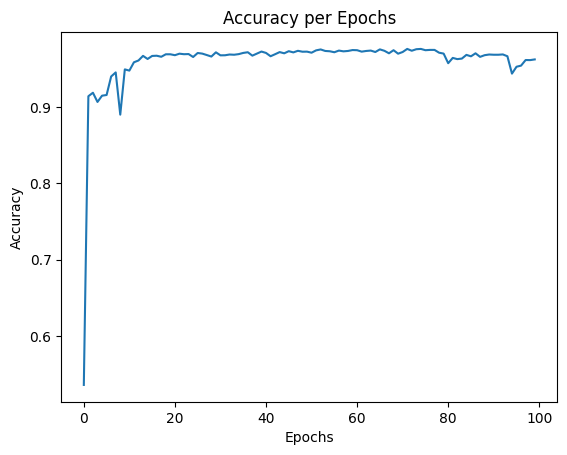

In [161]:

if __name__ == "__main__":
    cf = AttrDict() #cf = {}

    cf.n_epochs = 100
    cf.size_of_batch = 128
    cf.data_size = None

    cf.apply_inv = True
    cf.label_scale = 0.94
    cf.img_scale = 1.0
    cf.apply_scaling = True    
    

    cf.numperceptrons = [784, 500, 500, 10]
    cf.var_out = 1
    cf.activation_function = F.TANH
    cf.numlayers = len(cf.numperceptrons)    
    cf.variance = torch.ones(cf.numlayers)

    cf.inference_beta_parameter = 0.1
    cf.max_iterations = 50
    cf.threshold_option = 1e-6

    # optim parameters
    cf.lr = 1e-3
    cf.type_of_optimzer = "ADAM"
    cf.adam_beta_parameter_1 = 0.9
    cf.adam_beta_parameter_2 = 0.999
    cf.epsilon = 1e-8
    cf.decay_r = 0.9    

    cf.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    main(cf)


In [ ]:
cf = AttrDict() #cf = {}

cf.n_epochs = 100
cf.size_of_batch = 128
cf.data_size = None

cf.apply_inv = True
cf.label_scale = 0.94
cf.img_scale = 1.0
cf.apply_scaling = True    


cf.numperceptrons = [784, 500, 500, 10]
cf.var_out = 1
cf.activation_function = F.TANH
cf.numlayers = len(cf.numperceptrons)    
cf.variance = torch.ones(cf.numlayers)

cf.inference_beta_parameter = 0.1
cf.max_iterations = 50
cf.threshold_option = 1e-6

# optim parameters
cf.lr = 1e-3
cf.type_of_optimzer = "ADAM"
cf.adam_beta_parameter_1 = 0.9
cf.adam_beta_parameter_2 = 0.999
cf.epsilon = 1e-8
cf.decay_r = 0.9    

cf.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")